In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import itertools 
import shap

In [2]:
def load_and_describe_data(data_file):
    df = pd.read_csv(data_file)
    df.rename(columns={'MEDV': 'median_price'}, inplace=True)
    print(f'Num rows : {df.shape[0]}')
    print(f'Num features : {df.shape[1] - 1}')
    
    print(f'Meaning of features')
    feature_names = '''
CRIM      per capita crime rate by town
ZN        proportion of residential land zoned for lots over ,000 sq.ft.
INDUS     proportion of non-retail business acres per town
CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX       nitric oxides concentration (parts per 10 million)
RM        average number of rooms per dwelling
AGE       proportion of owner-occupied units built prior to 1940
DIS       weighted distances to five Boston employment centres
RAD       index of accessibility to radial highways
TAX      full-value property-tax rate per $10,000
PTRATIO  pupil-teacher ratio by town
B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT    % lower status of the population
'''
    print(feature_names)
    print(df.describe())
    
    print(f'\nCorrelation of features to median price')
    correlation = df.corr()['median_price'].sort_values(ascending=False)
    print(correlation)
    return df

In [3]:
df = load_and_describe_data('housing.csv')

Num rows : 506
Num features : 13
Meaning of features

CRIM      per capita crime rate by town
ZN        proportion of residential land zoned for lots over ,000 sq.ft.
INDUS     proportion of non-retail business acres per town
CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX       nitric oxides concentration (parts per 10 million)
RM        average number of rooms per dwelling
AGE       proportion of owner-occupied units built prior to 1940
DIS       weighted distances to five Boston employment centres
RAD       index of accessibility to radial highways
TAX      full-value property-tax rate per $10,000
PTRATIO  pupil-teacher ratio by town
B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT    % lower status of the population

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779 

In [4]:
def get_training_test_data(df):
    result = {}
    X = df.drop('median_price', axis=1)
    y = df['median_price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    result['X_train'] = X_train
    result['y_train'] = y_train
    result['X_test'] = X_test
    result['y_test'] = y_test
    
    
    return result

In [5]:
def plot_predictions(y_pred, y_test, model_name):
    '''
    Plots the difference between the predictions y_pred vs the actual values y_test
    '''
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predicted Price vs Actual Price')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual Values')
    plt.legend()
    plt.grid()
    plt.savefig(f'{model_name}_predictions.png' )
    plt.show()
    

In [6]:
def fit_linear_regression_model(X_train, y_train, X_test, y_test):
  
    model = LinearRegression()
    model.fit(X_train, y_train)
    coefficients = model.coef_
    intercept = model.intercept_
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f'Plain linear regression model')
    print(f'Mean squared error : {mse:.3f}')
    rmse = np.sqrt(mse)
    print(f'Root mean squared error : {rmse:.3f}')
    print(f'Mean absolute error : {mae:.3f}')
    plot_predictions(y_pred, y_test, 'simple_linear_regression')
    
    coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
    })
    print(f'{coef_df}')
    print(f'Model intercept : {intercept}')

In [7]:
def holdout_grid_search(clf, Xtrain, ytrain, Xtest, ytest, hyperparams, fixed_hyperparams={}):
    """
    Performs grid search on the validation dataset to find the best hyperparameters.
    """
    best_estimator = None 
    best_hyperparams = {}
    
    best_score = 0.0
    
    # get list of param values
    lists = hyperparams.values()
    # get all param combinations names to values in best_estimator
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)
    
    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):
        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
        
        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)
    
        # fit estimator
        estimator.fit(Xtrain, ytrain)
        # get predictions on the test
        y_preds = estimator.predict(Xtest)
        mse = mean_squared_error(ytest, y_preds)
    
#        print(f'[{i}/{total_param_combinations}] {param_dict}')
#        print(f'Val MSE: {mse}\n')
    
        if mse >= best_score:
            best_score = mse
            best_estimator = estimator
            best_hyperparams = param_dict
        
    best_hyperparams.update(fixed_hyperparams)
    
    return best_estimator, best_hyperparams

In [8]:
def explain_model(classifier, X_importance):
    """
    Generates SHAP plots for the given classifier.
    """
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_importance)
    shap.summary_plot(shap_values, X_importance)

In [9]:
def fit_random_forest_regression_model(X_train, y_train, X_test, y_test):
    X_dev, X_val, y_dev, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    hyperparams = {
        'n_estimators': [25, 50, 75, 100, 125, 150],
        'max_depth': [3,4,5,6,7,8,9,10],
        'min_samples_leaf': [5,6,7,8,9,10]
    }
    fixed_hyperparams = {
        'random_state': 21
    }
    
    clf = RandomForestRegressor
#    clf.fit(X_dev, y_dev)
#    print(f'Criteria : {clf.criterion}')
#    best_clf = clf
    best_clf, best_hyperparams = holdout_grid_search(clf, X_dev, y_dev, X_val, y_val, hyperparams, fixed_hyperparams)
    print(f"Best hyperparameters:\n{best_hyperparams}")
    
    y_pred = best_clf.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f'Random Forest Regressor model')
    print(f'Mean squared error : {mse:.3f}')
    rmse = np.sqrt(mse)
    print(f'Root mean squared error : {rmse:.3f}')
    print(f'Mean absolute error : {mae:.3f}')
    plot_predictions(y_pred, y_test, 'random_forest_regression')
    explain_model(best_clf, X_test)

In [10]:
def analyze_data(df):
    result = get_training_test_data(df)
    X_train = result['X_train']
    y_train = result['y_train']
    X_test = result['X_test']
    y_test = result['y_test']
    
    print(f'Shape of training set : {X_train.shape}')
    print(X_train.describe())
    print()
    print(f'Shape of test set : {X_test.shape}')
    print(X_test.describe())
    
    fit_linear_regression_model(X_train, y_train, X_test, y_test)
    fit_random_forest_regression_model(X_train, y_train, X_test, y_test)

Shape of training set : (404, 13)
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean     3.378976   10.992574   11.000545    0.074257    0.550923    6.273290   
std      7.791667   22.597046    6.824072    0.262514    0.113065    0.697196   
min      0.006320    0.000000    0.740000    0.000000    0.389000    4.138000   
25%      0.082973    0.000000    5.190000    0.000000    0.449000    5.874750   
50%      0.253715    0.000000    8.560000    0.000000    0.532000    6.179000   
75%      3.202962   12.500000   18.100000    0.000000    0.624000    6.619750   
max     73.534100   95.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean    68.081931    3.795402    9.445545  404.695545   18.436634  363.378

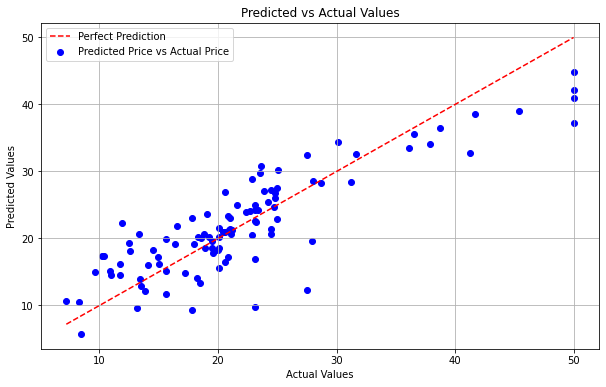

    Feature  Coefficient
0      CRIM    -0.075957
1        ZN     0.042377
2     INDUS     0.016432
3      CHAS     2.838339
4       NOX   -18.276177
5        RM     4.332665
6       AGE    -0.002793
7       DIS    -1.474854
8       RAD     0.294135
9       TAX    -0.012942
10  PTRATIO    -0.861111
11        B     0.008856
12    LSTAT    -0.482091
Model intercept : 31.970665539362567
Best hyperparameters:
{'n_estimators': 75, 'max_depth': 3, 'min_samples_leaf': 7, 'random_state': 21}
Random Forest Regressor model
Mean squared error : 13.678
Root mean squared error : 3.698
Mean absolute error : 2.704


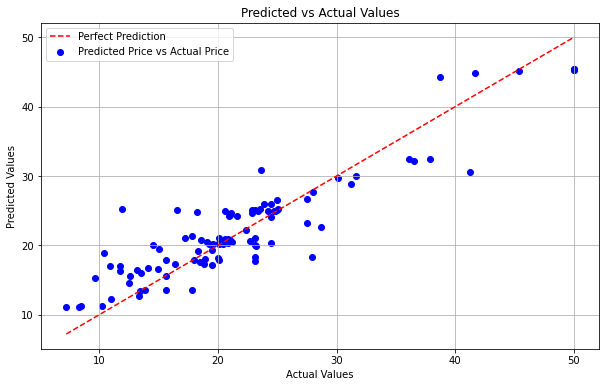

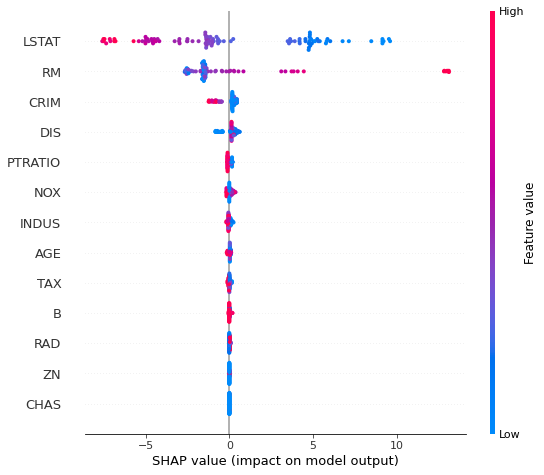

In [11]:
analyze_data(df)

The SHAP plot for the Random Forest classifier shows that house prices increase as the number of rooms increase. Moreover, house price decrease as LSTAT (% of the lower status of the population) and CRIM (per capita crime rate) increase. Moreover, the house price is inversely proportional to DIS (the distance from emoloyment).

Intuitively, these make sense.